#### Setup

In [2]:
# tokenization
import json
import MeCab
import demoji
import mojimoji
import re
from stopwords_ja import stop_words
from stopwords_slothlib import stop_words_2

# word2vec
import gensim, logging

# plotting
from sklearn.manifold import TSNE               
import numpy as np                
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# lda topic modelling
import pandas as pd
from pprint import pprint
import gensim
from gensim.corpora import Dictionary
from gensim import corpora
# import gensim.corpora as corpora
# from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
import scipy.sparse as sp
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
# import pyLDAvis
# import pyLDAvis.sklearn

#### Clean and Tokenize Tweets

In [3]:
# preprocess tweet content
def preprocess(text):    
    # from https://colab.research.google.com/drive/1bX-JyY4xmCm_RFkJg3QNcthUvEJaBghP
    # handle half-width/full-width chars, jp punctuation
    text = text.lower()
    text = mojimoji.zen_to_han(text, kana=False)
    text = mojimoji.han_to_zen(text, digit=False, ascii=False)
    text = text.translate(str.maketrans({
        '!': '！', '"': '”', '#': '＃', '$': '＄', '%': '％', '&': '＆', '\'': '’',
        '(': '（', ')': '）', '*': '＊', '+': '＋', ',': '，', '-': '−', '.': '．',
        '/': '／', ':': '：', ';': '；', '<': '＜', '=': '＝', '>': '＞', '?': '？',
        '@': '＠', '[': '［', '\\': '＼', ']': '］', '^': '＾', '_': '＿', '`': '｀',
        '{': '｛', '|': '｜', '}': '｝'
        }))
    zenkaku_leftsingle = b'\xe2\x80\x98'.decode('utf-8')
    text = re.sub('[’´｀]', zenkaku_leftsingle, text)
    
    # remove twitter-specific strings (handles, hashtags, etc.)
    text = re.sub("@([a-zA-Z0-9_]+)", "", text)
    text = re.sub("#([a-zA-Z0-9_ぁ-んァ-ン一-龠]+)", "", text)
    text = re.sub("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", "", text)

    # remove emojis
    text = demoji.replace(text, "")
    text = re.sub("([\uD83E-\uD83E])+", "", text)

    # remove punctuation and whitespace
    text = re.sub("([^一-龯ぁ-んァ-ン])+","",text)  
    text = re.sub("(\s)+", "", text)

    return text

In [6]:
# tokenize cleaned tweets into words
def tokenize(text):
    mt = MeCab.Tagger("-d /usr/local/lib/mecab/dic/mecab-ipadic-neologd")
    parsed = mt.parseToNode(text)
    components = []
    
    while parsed:
        word = parsed.surface
        pos = parsed.feature.split(",")[0]

        # remove beg/end tokens, particles, fillers, auxiliary bound prefixes/endings
        exclude_pos = ['BOS/EOS', '助詞', 'フィラー', '接頭詞', '助動詞']
        if pos not in exclude_pos: components.append(word)
        parsed = parsed.next
    
    # remove stopwords
    components = [token for token in components if ((not token in stop_words) and (not token in stop_words_2))]
    
    return components

In [4]:
# run preprocessing and tokenization for all tweets from given year dataset
def preprocess_tokenize_all(year):
    # store results and exception tweets
    tokens = []
    retweets = []
    not_parsed = []

    # iterate through tweets, preprocess and tokenize
    with open(year + '-all.txt', 'r') as file:
        for line in file:
            tweet = json.loads(line)
            if line == None or tweet == None:
                not_parsed.append((line, tweet))
                print("Parsing error: ", line, tweet)
            elif tweet['retweetedTweet']:
                retweets.append(tweet)
                print("Retweet: ", tweet['id'])
            else: 
                tweet_text = tweet['rawContent'] # note: need other prop for over 140 char?
                # preprocess text
                processed = preprocess(tweet_text)            
                # tokenize with mecab
                components = tokenize(processed)
                tokens.append(components)

    file.close()
    return tokens, retweets, not_parsed

In [9]:
# # run for 2015
# tokens_2015, retweets_2015, not_parsed_2015 = preprocess_tokenize_all("2015")

# # did we get retweets or errors?
# print(len(retweets_2015))
# print(len(not_parsed_2015))

In [8]:
# run for 2022
tokens_2022, retweets_2022, not_parsed_2022 = preprocess_tokenize_all("2022")

# did we get retweets or errors?
print(len(retweets_2022))
print(len(not_parsed_2022))

0
0


#### Word2Vec

In [7]:
# train and save word2vec model for given year
def run_word2vec(year, tokens):
    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
    model = gensim.models.Word2Vec(tokens, min_count=10)
    model.save("thesis_w2v_" + year + "_tweets")

In [8]:
# train and save word2vec model for 2015 
run_word2vec("2015", tokens_2015)

2023-12-27 14:18:40,328 : INFO : collecting all words and their counts
2023-12-27 14:18:40,334 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2023-12-27 14:18:40,375 : INFO : PROGRESS: at sentence #10000, processed 80576 words, keeping 20628 word types
2023-12-27 14:18:40,398 : INFO : PROGRESS: at sentence #20000, processed 163751 words, keeping 28771 word types
2023-12-27 14:18:40,419 : INFO : PROGRESS: at sentence #30000, processed 240143 words, keeping 37917 word types
2023-12-27 14:18:40,459 : INFO : PROGRESS: at sentence #40000, processed 320405 words, keeping 45289 word types
2023-12-27 14:18:40,480 : INFO : PROGRESS: at sentence #50000, processed 399765 words, keeping 51821 word types
2023-12-27 14:18:40,509 : INFO : PROGRESS: at sentence #60000, processed 476156 words, keeping 53898 word types
2023-12-27 14:18:40,534 : INFO : PROGRESS: at sentence #70000, processed 553893 words, keeping 54912 word types
2023-12-27 14:18:40,564 : INFO : PROGRESS: at s

In [9]:
# train and save word2vec model for 2022
run_word2vec("2022", tokens_2022)

2023-12-27 14:18:56,026 : INFO : collecting all words and their counts
2023-12-27 14:18:56,028 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2023-12-27 14:18:56,047 : INFO : PROGRESS: at sentence #10000, processed 80462 words, keeping 16625 word types
2023-12-27 14:18:56,096 : INFO : PROGRESS: at sentence #20000, processed 159565 words, keeping 20951 word types
2023-12-27 14:18:56,117 : INFO : PROGRESS: at sentence #30000, processed 241422 words, keeping 32244 word types
2023-12-27 14:18:56,152 : INFO : PROGRESS: at sentence #40000, processed 319983 words, keeping 40793 word types
2023-12-27 14:18:56,186 : INFO : PROGRESS: at sentence #50000, processed 397617 words, keeping 44689 word types
2023-12-27 14:18:56,216 : INFO : PROGRESS: at sentence #60000, processed 479082 words, keeping 46657 word types
2023-12-27 14:18:56,249 : INFO : PROGRESS: at sentence #70000, processed 559626 words, keeping 51208 word types
2023-12-27 14:18:56,268 : INFO : PROGRESS: at s

In [10]:
# load trained word2vec model
model_2015 = gensim.models.Word2Vec.load("thesis_w2v_2015_tweets")

# check similarity given by trained model
print(model_2015.wv.most_similar(positive='在日',topn=10))
print(model_2015.wv.most_similar(positive='外国人',topn=10))

2023-12-27 14:19:18,615 : INFO : loading Word2Vec object from thesis_w2v_2015_tweets
2023-12-27 14:19:18,669 : INFO : loading wv recursively from thesis_w2v_2015_tweets.wv.* with mmap=None
2023-12-27 14:19:18,671 : INFO : setting ignored attribute cum_table to None
2023-12-27 14:19:18,891 : INFO : Word2Vec lifecycle event {'fname': 'thesis_w2v_2015_tweets', 'datetime': '2023-12-27T14:19:18.891225', 'gensim': '4.3.2', 'python': '3.11.5 (main, Aug 24 2023, 15:18:16) [Clang 14.0.3 (clang-1403.0.22.14.1)]', 'platform': 'macOS-13.5-x86_64-i386-64bit', 'event': 'loaded'}


[('密輸', 0.9225761890411377), ('社説', 0.921892523765564), ('皇太子', 0.9214861392974854), ('日刊ゲンダイ', 0.9205718636512756), ('半島', 0.9186257719993591), ('領土', 0.9182296395301819), ('偽装', 0.9176166653633118), ('緊縮', 0.9176071882247925), ('戦争犯罪', 0.917079508304596), ('霞', 0.9158768057823181)]
[('他国', 0.9100844860076904), ('外国', 0.9091653823852539), ('中国人', 0.9011421799659729), ('日本人', 0.8940977454185486), ('移民', 0.8915354609489441), ('難民', 0.8761928081512451), ('左翼', 0.8747358322143555), ('国会議員', 0.8564897775650024), ('若者', 0.8546940684318542), ('雇用', 0.8544275164604187)]


In [11]:
# same for 2022
model_2022 = gensim.models.Word2Vec.load("thesis_w2v_2022_tweets")

print(model_2022.wv.most_similar(positive='在日',topn=10))
print(model_2022.wv.most_similar(positive='外国人',topn=10))

2023-12-27 14:19:20,091 : INFO : loading Word2Vec object from thesis_w2v_2022_tweets
2023-12-27 14:19:20,133 : INFO : loading wv recursively from thesis_w2v_2022_tweets.wv.* with mmap=None
2023-12-27 14:19:20,133 : INFO : setting ignored attribute cum_table to None
2023-12-27 14:19:20,339 : INFO : Word2Vec lifecycle event {'fname': 'thesis_w2v_2022_tweets', 'datetime': '2023-12-27T14:19:20.339315', 'gensim': '4.3.2', 'python': '3.11.5 (main, Aug 24 2023, 15:18:16) [Clang 14.0.3 (clang-1403.0.22.14.1)]', 'platform': 'macOS-13.5-x86_64-i386-64bit', 'event': 'loaded'}


[('共産主義', 0.9306224584579468), ('併合', 0.9204510450363159), ('略奪', 0.9177254438400269), ('ナチス', 0.914193332195282), ('イラク', 0.9130715131759644), ('軍事力', 0.9127207398414612), ('従わ', 0.9111466407775879), ('人身売買', 0.9108579158782959), ('諸国', 0.9105721712112427), ('辺野古', 0.9075276255607605)]
[('中国人', 0.8970280885696411), ('自国', 0.894239604473114), ('欧米', 0.8910224437713623), ('中国', 0.8830902576446533), ('日本人', 0.8747531175613403), ('れいわ', 0.8741739988327026), ('イスラム教', 0.8676839470863342), ('独立', 0.8672612905502319), ('教会', 0.8656696677207947), ('カルト', 0.8599515557289124)]


#### Plot Word2Vec Findings

In [12]:
# https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#sphx-glr-auto-examples-tutorials-run-word2vec-py

def reduce_dimensions(model):
    num_dimensions = 2

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals

In [13]:
# plot similar words
# https://aneesha.medium.com/using-tsne-to-plot-a-subset-of-similar-words-from-word2vec-bb8eeaea6229 
# https://albertauyeung.github.io/2020/03/15/matplotlib-cjk-fonts.html/
# https://stackoverflow.com/questions/70268270/how-to-plot-tsne-on-word2vec-created-from-gensim-for-the-most-similar-20-cases

def plot_closest_words(word, model, x_vals, y_vals):
    labels = [i for i in model.wv.index_to_key]
    close_words = [i[0] for i in model.wv.most_similar(positive=word, topn=15)]

    fprop = fm.FontProperties(fname='NotoSansJP-VariableFont_wght.ttf')
    for word in close_words:
        i = labels.index(word)
        plt.scatter(x_vals[i],y_vals[i])
        plt.annotate(labels[i], xy=(x_vals[i], y_vals[i]), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom', fontproperties=fprop)

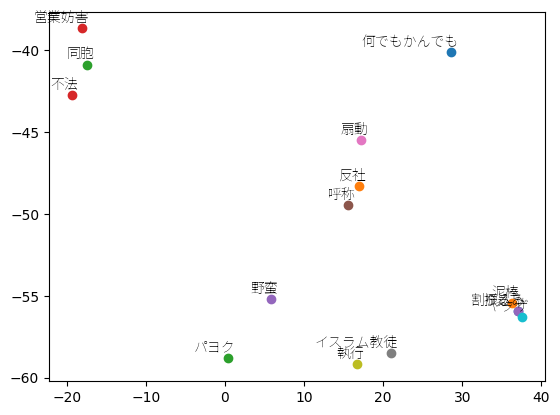

In [14]:
x_vals, y_vals = reduce_dimensions(model_2015)
plot_closest_words("外人", model_2015, x_vals, y_vals)

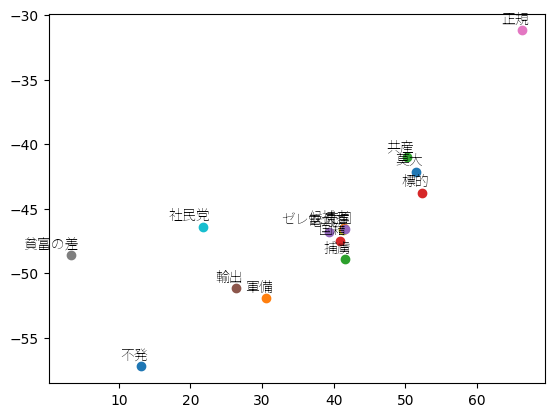

In [21]:
x_vals, y_vals = reduce_dimensions(model_2022)
plot_closest_words("外人", model_2022, x_vals, y_vals)

In [15]:
model_2015.wv.most_similar(positive="外人", topn=15)

[('割り込み', 0.8860533237457275),
 ('反社', 0.8832544684410095),
 ('同胞', 0.8824900388717651),
 ('不法', 0.8819209337234497),
 ('振るう', 0.8811072707176208),
 ('呼称', 0.8809957504272461),
 ('扇動', 0.876920759677887),
 ('イスラム教徒', 0.8765144944190979),
 ('執行', 0.8759120106697083),
 ('ヤクザ', 0.8744602799415588),
 ('何でもかんでも', 0.8738333582878113),
 ('泥棒', 0.8737172484397888),
 ('パヨク', 0.8736859560012817),
 ('営業妨害', 0.8731456995010376),
 ('野蛮', 0.8725719451904297)]

In [16]:
model_2022.wv.most_similar(positive="外人", topn=15)

[('不発', 0.8506039977073669),
 ('軍備', 0.8255631923675537),
 ('共産', 0.8236428499221802),
 ('国籍', 0.821510910987854),
 ('電力', 0.8174948692321777),
 ('輸出', 0.8158841133117676),
 ('正規', 0.8158621191978455),
 ('貧富の差', 0.8142353892326355),
 ('ゼレンスキ', 0.8098755478858948),
 ('社民党', 0.8073658347129822),
 ('莫大', 0.807080090045929),
 ('候補者', 0.8061603903770447),
 ('捕虜', 0.8054761290550232),
 ('標的', 0.8051358461380005),
 ('売国', 0.8046982288360596)]

In [17]:
words = model_2015.wv.most_similar(positive="在日", topn=15)
for word in words:
    print(word[0])

密輸
社説
皇太子
日刊ゲンダイ
半島
領土
偽装
緊縮
戦争犯罪
霞
結託
似非
邪教
カタル
東京地検特捜部


In [18]:
words = model_2022.wv.most_similar(positive="在日", topn=15)
for word in words:
    print(word[0])

共産主義
併合
略奪
ナチス
イラク
軍事力
従わ
人身売買
諸国
辺野古
クルド人
イスラム
ひろゆき
核
菅


In [22]:
common = model_2015.wv.index_to_key[:50]
for word in common:
    print(word)

てる
おはよう
ありがとう
今日
いい
おは
ください
くれ
フォロ
参加
思っ
すぎ
好き
やっ
み
笑
応募
お願い
来
良い
キャンペン
くん
結果
思う
もう
楽しみ
寝
言っ
仕事
思い
すぎる
良かっ
よろしく
出
行っ
朝
食べ
明日
配信
欲しい
昨日
よろしくお願いします
おめでとう
待っ
ぜひ
嬉しい
どう
っ
動画
本当に


In [23]:
common = model_2022.wv.index_to_key[:50]
for word in common:
    print(word)

てる
おはよう
ありがとう
今日
いい
ください
おは
くれ
思っ
参加
すぎ
好き
結果
笑
やっ
み
良い
寝
フォロ
お願い
明日
くん
来
もう
思う
朝
昨日
言っ
キャンペン
すぎる
行っ
出
楽しみ
動画
思い
応募
食べ
っ
仕事
どう
嬉しい
当たる
ござい
おめでとう
起き
可愛い
まだ
本当に
よろしくお願いします
残念


#### LDA Topic Modelling

In [10]:
# https://lda.readthedocs.io/en/latest/getting_started.html
# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
# https://github.com/deankuo/Japan-Manifesto-Classification/blob/main/topic_modeling.ipynb

# https://github.com/m3yrin/NTM/blob/master/LDA_jp.ipynb

# build dict
d = corpora.Dictionary(tokens_2022)
d.filter_extremes(no_below=5, no_above=0.2)
d.compactify()

# make bow
corpus = [d.doc2bow(w) for w in tokens_2022]
# test train split
test_size = int(len(corpus) * 0.1)
test_corpus = corpus[:test_size]
train_corpus = corpus[test_size:]
     
# logging setting
logging.basicConfig(format='%(message)s', level=logging.INFO)

# build LDA
topic_num = 20
lda = gensim.models.LdaModel(corpus=train_corpus, id2word=d,num_topics=topic_num,passes=10, update_every=5)
    
# look at results
# N = sum(count for doc in train_corpus for id, count in doc)
# print("# of words in train corpas: ",N)
# perplexity = np.exp2(-lda.log_perplexity(train_corpus))
# print("perplexity(train):", perplexity)

# print("==============================")
# N = sum(count for doc in test_corpus for id, count in doc)
# print("# of words in test corpas: ",N)
# perplexity = np.exp2(-lda.log_perplexity(test_corpus))
# print("perplexity(test):", perplexity)

def get_topic_words(topic_id):
    tw = []
    for t in lda.get_topic_terms(topic_id):
        tw.append(d[t[0]])
    
    return tw

for t in range(topic_num):
    tw = get_topic_words(t)
    print('Topic {}: {}'.format(t + 1, ' '.join(tw)))

using symmetric alpha at 0.05
using symmetric eta at 0.05
using serial LDA version on this node
running online (multi-pass) LDA training, 20 topics, 10 passes over the supplied corpus of 508891 documents, updating model once every 10000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
PROGRESS: pass 0, at document #2000/508891
PROGRESS: pass 0, at document #4000/508891
PROGRESS: pass 0, at document #6000/508891
PROGRESS: pass 0, at document #8000/508891
PROGRESS: pass 0, at document #10000/508891
merging changes from 10000 documents into a model of 508891 documents
topic #8 (0.050): 0.018*"てる" + 0.015*"おはよう" + 0.011*"今日" + 0.007*"ござい" + 0.007*"ありがとう" + 0.006*"朝" + 0.005*"み" + 0.005*"寒い" + 0.004*"ください" + 0.004*"いい"
topic #6 (0.050): 0.014*"今日" + 0.011*"おはよう" + 0.008*"おは" + 0.008*"てる" + 0.007*"寝" + 0.006*"ありがとう" + 0.006*"ください" + 0.005*"いい" + 0.005*"くれ" + 0.004*"どう"
topic #7 (0.050): 0.015*"てる" + 0.014*"おは" + 0.010*"おはよう" + 0.0

Topic 1: 来 欲しい 凸 いいね くれ 繋がり リプ マン 初めて ふ
Topic 2: 楽しみ 缶 スパ 投稿 白 やっと 赤 おき フォロ 選ん
Topic 3: 月日 読ん 開催 作品 無料 なし ガチャ 覚え こんばんは 必ず
Topic 4: 日本 言う 世界 問題 人間 思う せい てる 思い 女性
Topic 5: 動画 待っ 確認 てる まじ これから く 周年 入り 裏
Topic 6: おめでとう かわいい 曲 募集 誕生日 交換 ください 終わり 予約 大阪
Topic 7: 寝 起き やっ 明日 いっぱい おやすみ くれ 行き 寝る 早く
Topic 8: おは すぎ っ すごい 位 ありがと おやすみなさい め 火曜日 大人
Topic 9: お願い よろしく 致し ありがとう いたし 失礼 フォロ 頂き 反応 宜しく
Topic 10: てる 思っ 思う 可愛い 言っ いい どう やっ 言わ よく
Topic 11: ありがとう 参加 最後 抽選 結果 引用 いただき ポスト キャンペン 友達
Topic 12: 笑 くん 食べ 出 てる くる 買っ ちゃっ ちょっと すぎ
Topic 13: おはよう 今日 朝 頑張っ よろしくお願いします お疲れ様 素敵 ござい 雨 仕事
Topic 14: 好き すぎる 最高 めっちゃ 行く 写真 すぎ めちゃくちゃ 楽しかっ いい
Topic 15: み てる もっと 推し 知っ お誕生日おめでとう 神 ください お前 ほろよい
Topic 16: 嬉しい 大丈夫 大好き 本当に 出来 好き てる 幸せ とても 番
Topic 17: やる やり 作っ 垢 絶対 やばい キャラ 入れ 人生 ジャニズ
Topic 18: いい てる 東京 とこ なんで 着 モンスト 見え 強 やはり
Topic 19: ください 結果 参加 ぜひ ハズレ ありがとう チャレンジ 応募 可能 キャンペン
Topic 20: よかっ 僕 てる 気持ち 仲良く 人妻 絵 言葉 フォロ 探し


In [14]:
print(tokens_2022[2])

['エチエチ', '姿', 'くれる', '欲し', 'い人', 'いいね', '来', 'プロフ', '来', 'ぱい', '凸', 'フロイニ']


In [16]:
doc_topic = lda.doc_topic_
for i in range(10):
    print("{} (top topic: {})".format(titles[i], doc_topic[i].argmax()))

AttributeError: 'LdaModel' object has no attribute 'doc_topic_'